In [1]:
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
%matplotlib inline

Stuff to figure out:
- Does the blackjack class terminate an episode when a player either reaches 21 or goes bust? I don't think so. 
- Make it terminate when going bust/ reaching 21
- Incorporate gym.Env functionality for stepping the environment, resetting it, rendering, etc.
- Plot state-value function learned in order to determine if it matches with the function found by the book and by Denny Britz

In [123]:
class blackjack_game(gym.Env):
    def __init__(self):
        self.cards = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10])
        
    def drawtwocards(self):
        rand_cards = np.random.randint(0, len(self.cards), size=2)
        return rand_cards
    
    def drawonecard(self):
        rand_card = np.random.randint(0, len(self.cards))
        return rand_card
    
    def computepoints(self, rand_cards):
        points = 0
        hand = self.cards[rand_cards]
        if np.isin(1, hand):
            if np.sum(hand) + 10 <= 21:
                points = np.sum(hand) + 10
        else:
            points = np.sum(hand)
            
        return points
    
    def dealerplay(self, point_total):
        # 1 is hit, 0 is stick
        if point_total < 17:
            return 1
        elif point_total >= 17:
            return 0
        
    def agent_obs(self, agent_cards, dealer_cards):
        a_points = self.computepoints(agent_cards)
        d_points = self.computepoints(dealer_cards)
        agent_ace_usable = int(a_points <= 10)
        return a_points, d_points, agent_ace_usable
    
    def check_win(self, agent_cards, dealer_cards, both_done_playing):
        agent_points = self.computepoints(agent_cards)
        dealer_points = self.computepoints(dealer_cards)
        agent_win, dealer_win = 0, 0
        if agent_points == 21: agent_win += 1
        if dealer_points == 21: dealer_win += 1
        
        if agent_points > 21: return -1
        if dealer_points > 21: return 1
        
        if both_done_playing and agent_points > dealer_points:
            agent_win += 1
        if both_done_playing and dealer_points > agent_points:
            dealer_win += 1
        if both_done_playing and dealer_points == agent_points:
            return 0
         
        if agent_win == dealer_win: return 0
        if agent_win > dealer_win: return 1
        if agent_win < dealer_win: return -1
        
        
    def visualize(self, points, turn, action):
        if turn is 1: player = 'MC'
        elif turn is 0: player = 'dealer'
        
        print(player, 'has', points, ' points')
        print(player, 'chooses to', action)
        print()
        
    def play(self, start, policy):
        sequence = []
        a_cards, d_cards = self.cards[self.drawtwocards()], self.cards[self.drawtwocards()]
        both_done_playing = False
        count = 0
        while both_done_playing is False:
            if start == True:
                start = False
                dealer_turn = False
                a_turn = True
            
            if a_turn is True and dealer_turn is False:
                a_obs = self.agent_obs(a_cards, [d_cards[0]])
                a_action = policy(a_obs[0])
                if a_action is 1:
                    a_cards = np.append(a_cards, self.cards[self.drawonecard()])
                elif a_action is 0:
                    a_turn = False
                    dealer_turn = True
                    
            if dealer_turn is True and a_turn is False:
                d_action = self.dealerplay(self.computepoints(d_cards))
                a_obs = self.agent_obs(a_cards, d_cards)
                if d_action is 1:
                    d_cards = np.append(d_cards, self.cards[self.drawonecard()])
                elif d_action is 0:
                    both_done_playing = True
                    #self.check_win(a_cards, d_cards, both_done_playing)
                    
            if self.computepoints(a_cards) > 21 or self.computepoints(d_cards) > 21:
                both_done_playing = True
                a_obs = self.agent_obs(a_cards, d_cards)
                sequence.append(np.array([a_obs, a_action, self.check_win(a_cards, d_cards, both_done_playing)]))
                break
            sequence.append(np.array([a_obs, a_action, self.check_win(a_cards, d_cards, both_done_playing)]))
            count += 1
        return sequence

In [124]:
game = blackjack_game()
a_cards, d_cards = game.drawtwocards(), game.drawtwocards()
game.check_win(a_cards, d_cards, True)

-1

In [185]:
policy = lambda x: 1 - int(x >= 20)
sequence = game.play(True, policy)

In [188]:
np.asarray(sequence)[0:].shape[0]


4

In [301]:
class monte_carlo:
    def __init__(self, num_states, environment, gamma):
        self.num_states = num_states
        self.env = environment()
        self.gamma = gamma
    
    def find_first_visit(self, state, states):
        for i in range(len(states)):
            if states[i] == state:
                return i

    def first_visit_MC_prediction(self, policy, epochs):
        V_ = defaultdict(float)
        returns = defaultdict(float)
        count = defaultdict(float)
         
        for ep in range(epochs):
            episode = np.asarray(self.env.play(True, policy=policy))
            states = episode[:, 0]
            G = 0
            for state in states:
                first = self.find_first_visit(state, states)
                discount_vec = np.power(np.full(len(episode[first:]), self.gamma), np.arange(len(episode[first:])))
                reward_vec = episode[:, 2][first:]
                G = np.dot(discount_vec, reward_vec)
                returns[state] += G
                count[state] += 1
                V_[state] = returns[state] / count[state]
        return V_

In [294]:
a = np.power(np.full(5, 1), np.arange(5))
b = np.array([i for i in range(5)])
print(a, b)
np.dot(a, b)

[1 1 1 1 1] [0 1 2 3 4]


10

In [266]:
num_states = 200
policy(19)

1

In [302]:
mc = monte_carlo(200, blackjack_game, 1)

In [303]:
val_func = mc.first_visit_MC_prediction(policy, 10000)

4 29 2 26


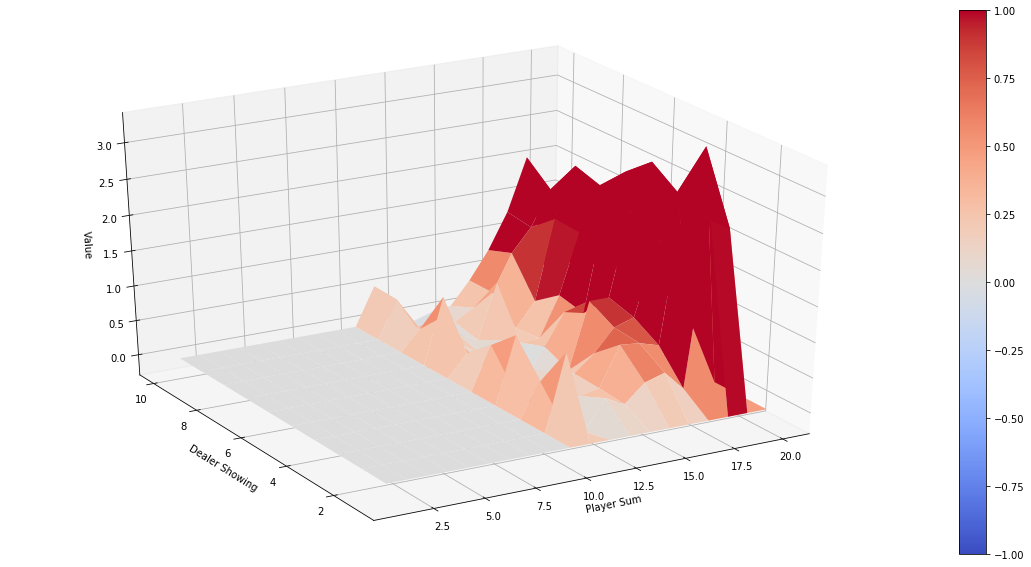

In [307]:
min_x = min(k[0] for k in val_func.keys())
max_x = max(k[0] for k in val_func.keys())
min_y = min(k[1] for k in val_func.keys())
max_y = max(k[1] for k in val_func.keys())
print(min_x, max_x, min_y, max_y)
x_range = np.arange(1, 21)
y_range = np.arange(1, 11)
X, Y = np.meshgrid(x_range, y_range)
Z_noace = np.apply_along_axis(lambda _: val_func[(_[0], _[1], False)], 2, np.dstack([X, Y]))
Z_ace = np.apply_along_axis(lambda _: val_func[(_[0], _[1], True)], 2, np.dstack([X, Y]))
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_noace, rstride=1, cstride=1,
    cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
ax.set_xlabel('Player Sum')
ax.set_ylabel('Dealer Showing')
ax.set_zlabel('Value')
ax.view_init(ax.elev, -120)
fig.colorbar(surf)
plt.show()

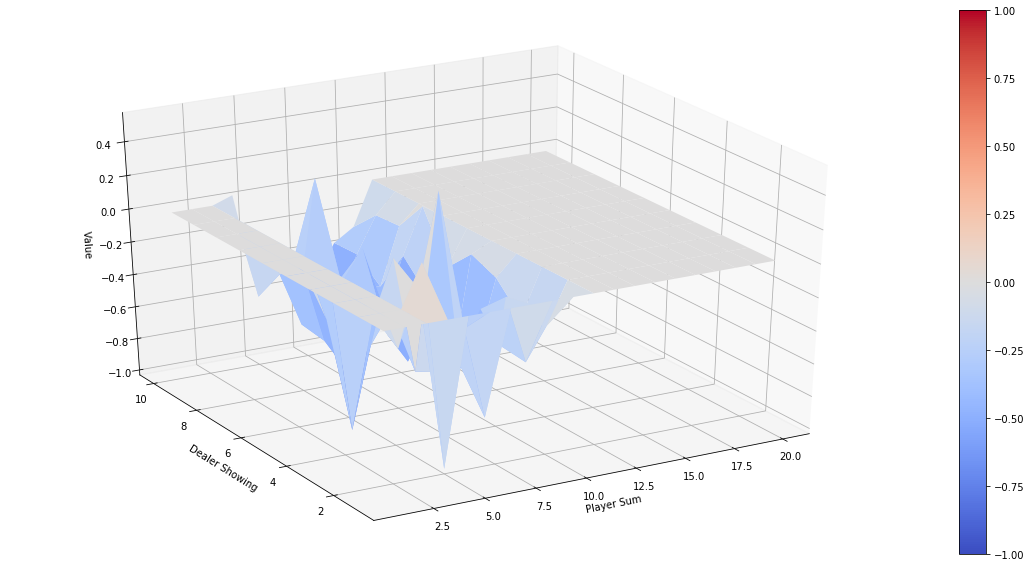

In [311]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_ace, rstride=1, cstride=1,
                       cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
ax.set_xlabel('Player Sum')
ax.set_ylabel('Dealer Showing')
ax.set_zlabel('Value')
ax.view_init(ax.elev, -120)
fig.colorbar(surf)
plt.show()

In [13]:
a

defaultdict(float, {})

In [320]:
import sys
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        #episode = []
        #state = env.reset()
        #for t in range(100):
        #    action = policy(state)
        #    next_state, reward, done, _ = env.step(action)
        #    episode.append((state, action, reward))
        #    if done:
        #        break
        #    state = next_state
        episode = env.play(True, policy)
        # Find all states the we've visited in this episode
        # We convert each state to a tuple so that we can use it as a dict key
        states_in_episode = set([tuple(x[0]) for x in episode])
        for state in states_in_episode:
            # Find the first occurance of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Calculate average return for this state over all sampled episodes
            returns_sum[state] += G
            returns_count[state] += 1.0
            V[state] = returns_sum[state] / returns_count[state]

    return V

In [322]:
func = mc_prediction(policy, blackjack_game(), 10000)

Episode 10000/10000.

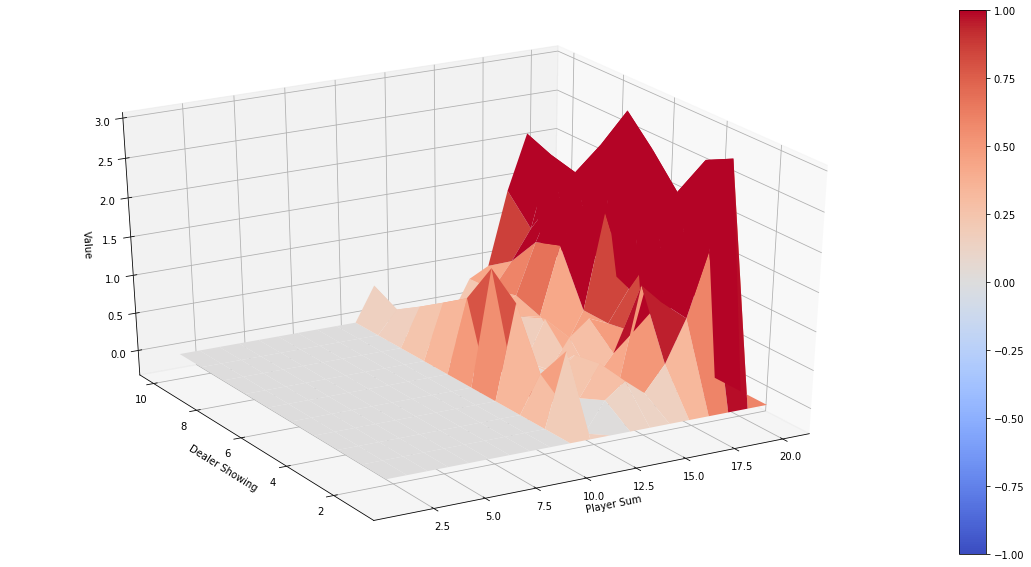

In [323]:
x_range = np.arange(1, 21)
y_range = np.arange(1, 11)
X, Y = np.meshgrid(x_range, y_range)
Z_noace = np.apply_along_axis(lambda _: func[(_[0], _[1], False)], 2, np.dstack([X, Y]))
Z_ace = np.apply_along_axis(lambda _: func[(_[0], _[1], True)], 2, np.dstack([X, Y]))
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z_noace, rstride=1, cstride=1,
    cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
ax.set_xlabel('Player Sum')
ax.set_ylabel('Dealer Showing')
ax.set_zlabel('Value')
ax.view_init(ax.elev, -120)
fig.colorbar(surf)
plt.show()